# Car Insurance Claims Forecasting

This notebook tackles the problem of **forecasting the number of car-insurance claims per policy period**.  
We treat it as a **count regression** task and explicitly account for the exposure time (policy at risk period).

The main goals are:

- Build a **clean, reproducible ML pipeline** that:
  - loads and cleans the data,
  - explores distributions and key risk drivers,
  - trains at least **two modeling approaches** (GLM-style and tree-based),
  - evaluates models with metrics suitable for **claim counts**.
- Provide **business-oriented insight**:
  - which factors drive claim frequency,
  - where the model underperforms,
  - what actions an insurer could take based on the results (pricing, underwriting, monitoring).

I use:

- A **generalized linear model (GLM)** with a Poisson objective (in a separate section) as a transparent baseline.
- **Gradient-boosted trees (XGBoost)** with Poisson/Tweedie objectives as a flexible, non-linear benchmark.
- Exposure enters the modeling in a way that the models effectively learn **claim frequency** (claims per exposure year) rather than raw counts.

# 1. Data and problem setup

The original dataset is based on the well-known **French motor third-party liability (MTPL)** portfolio.  
Each row represents a **policy-period** with:

- `IDpol`: policy identifier (join key across tables),
- `Exposure`: time at risk (in years),
- `ClaimNb`: number of reported claims during the exposure period,
- tariff variables and technical risk features such as:
  - `Area`, `Region`: geographic segmentation,
  - `VehPower`, `VehAge`, `VehBrand`, `VehGas`: vehicle characteristics,
  - `DrivAge`: driver age,
  - `BonusMalus`: bonus-malus score,
  - `Density`: population density of the policyholder’s area.

In this notebook I work on a **prepared version** of the dataset (`claims_prepared.csv`) where:
- basic quality checks are already applied,
- some categorical levels are **lumped** to control cardinality (e.g. `VehBrand_lumped`, `Region_lumped`),
- additional helper features are created (e.g. `logDensity`, banded versions of age/power/bonus).

The target of interest is:

> **Claim frequency** = expected number of claims during the exposure period  
> (exposure-adjusted via weights or offset).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_poisson_deviance, root_mean_squared_error, make_scorer

from xgboost import XGBRegressor, XGBClassifier

sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load prepared dataset
df = pd.read_csv("../data/claims_prepared.csv")

print(df.shape)
df.info()
df.head()

(678013, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ClaimNb          678013 non-null  int64  
 1   Exposure         678013 non-null  float64
 2   IDpol            678013 non-null  int64  
 3   Area             678013 non-null  object 
 4   VehBrand_lumped  678013 non-null  object 
 5   VehGas           678013 non-null  object 
 6   Region_lumped    678013 non-null  object 
 7   VehPower         678013 non-null  int64  
 8   VehAge           678013 non-null  int64  
 9   DrivAge          678013 non-null  int64  
 10  BonusMalus       678013 non-null  int64  
 11  Density          678013 non-null  int64  
 12  logDensity       678013 non-null  float64
 13  DrivAgeBand      678013 non-null  object 
 14  VehAgeBand       678013 non-null  object 
 15  BonusMalusBand   678013 non-null  object 
dtypes: float64(2), int64(7), 

,ClaimNb,Exposure,IDpol,Area,VehBrand_lumped,VehGas,Region_lumped,VehPower,VehAge,DrivAge,BonusMalus,Density,logDensity,DrivAgeBand,VehAgeBand,BonusMalusBand
0,1,0.10,1,D,B12,Regular,R82,5,0,55,50,1217,7.104965,45-59,0-2,50-59
1,1,0.77,3,D,B12,Regular,R82,5,0,55,50,1217,7.104965,45-59,0-2,50-59
2,1,0.75,5,B,B12,Diesel,Other,6,2,52,50,54,4.007333,45-59,0-2,50-59
3,1,0.09,10,B,B12,Diesel,R72,7,0,46,50,76,4.343805,45-59,0-2,50-59
4,1,0.84,11,B,B12,Diesel,R72,7,0,46,50,76,4.343805,45-59,0-2,50-59


# 2. Target, exposure and feature set

In claims modeling, **exposure** is crucial. A policy with half a year of exposure cannot be directly compared to a full-year policy.

In this notebook:

- The **target** is `ClaimNb` (number of claims during the period).
- `Exposure` is used as:
  - a **sample weight** in tree-based models (XGBoost),
  - and can act as an **offset** in GLM-type models (not shown here but used in my Poisson GLM section).

For the XGBoost models I focus on a mix of:
- **Tariff variables** (`Area`, `Region_lumped`, `BonusMalus`),
- **Technical risk** (`VehPower`, `VehAge`, `DrivAge`, `VehGas`, `logDensity`),
- and brand / region lumpings (`VehBrand_lumped`, `Region_lumped`) to avoid exploding cardinality.

The train/test split keeps the **original exposure distribution** and allows for a clean hold-out evaluation.

In [2]:
target_col = "ClaimNb"
exposure_col = "Exposure"
id_col = "IDpol"

# Mix of tariff and technical risk features for XGBoost.
xgb_feature_cols = [
    "Area",
    "VehBrand_lumped",
    "VehGas",
    "Region_lumped",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "logDensity",
]

X = df[xgb_feature_cols]
y = df[target_col]
exposure = df[exposure_col]

# Train/test split with a fixed random_state for reproducibility.
# Exposure is carried to keep a consistent hold-out evaluation with correct weights.
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X,
    y,
    exposure,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

X_train.shape, X_test.shape

((542410, 9), (135603, 9))

# 3. Exploratory Data Analysis (EDA)

Before modeling, I performed a short EDA to understand:

1. **Data quality**
   - Checked for missing values and impossible values (e.g. negative `Exposure`, negative `ClaimNb`).
   - Filtered out observations with non-positive exposure, since they do not meaningfully contribute to frequency modeling.

2. **Univariate distributions**
   - Histograms for `ClaimNb` (highly zero-inflated, as expected for MTPL),
   - Exposure distribution (most policies are close to 1 year, with some shorter exposures),
   - Age distributions for drivers and vehicles, `BonusMalus`, `Density`, etc.

3. **Bivariate relationships with claim frequency**
   - Average **claim frequency** (`ClaimNb / Exposure`) by:
     - `Area`, `Region_lumped` and `VehGas`,
     - `DrivAge` and `VehAge` bands,
     - `BonusMalus` bands.
   - This helps check whether the patterns align with underwriting intuition
     (young drivers, high BonusMalus, higher power, dense urban areas typically having higher frequencies).

These plots are not all included in the final report to keep it concise, but they informed:
- which variables to include in the model,
- how to treat extreme/outlier segments (e.g. very high BonusMalus or Density),
- where to expect model challenges (e.g. very low-volume cells with 2+ claims).

# 4. Preprocessing: numerical vs categorical features

For tree-based gradient boosting models I keep preprocessing deliberately simple:

- **Numeric variables** (`VehPower`, `VehAge`, `DrivAge`, `BonusMalus`, `logDensity`) are passed through as-is.
- **Categorical variables** (`Area`, `VehBrand_lumped`, `VehGas`, `Region_lumped`) are **one-hot encoded** with `handle_unknown="ignore"` to safely handle rare levels or levels present only in the test set.

This keeps the feature space interpretable while giving XGBoost access to non-linearities and interactions.

In [3]:
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", cat_features)
print("Numeric features:", num_features)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

Categorical features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped']
Numeric features: ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'logDensity']


# 5. Baseline models

Before moving to gradient-boosted trees, I benchmark against two simpler baselines:

1. **Naive portfolio average**
   - Predict the same **global mean claim count** for every policy.
   - This is a "flat tariff" and quantifies how much lift we get from any modeling at all.

2. **Poisson GLM frequency model** (standard actuarial baseline)
   - Uses `ClaimNb` as the response with a **log link** and includes an **offset of `log(Exposure)`**.
   - Predictors: tariff and risk variables (Area, Region, age, power, BonusMalus, etc.).
   - GLM is less flexible than XGBoost, but:
     - highly interpretable,
     - easy to implement in production rating formulas,
     - serves as a sanity check for signs and magnitudes of key coefficients.

I compare all later models against these baselines in terms of **Poisson deviance** and **RMSE** on the hold-out test set.

In [4]:
# Simple actuarial baseline: predict the same mean claim count for every policy.
global_mean_claim = y_train.mean()
print("Global mean ClaimNb (train):", global_mean_claim)

y_pred_baseline = np.full_like(y_test, fill_value=global_mean_claim, dtype=float)

baseline_poisson_dev = mean_poisson_deviance(y_test, y_pred_baseline)
baseline_rmse = root_mean_squared_error(y_test, y_pred_baseline)

print(f"Baseline Poisson deviance: {baseline_poisson_dev:.4f}")
print(f"Baseline RMSE:             {baseline_rmse:.4f}")

Global mean ClaimNb (train): 0.05320882727088365
Baseline Poisson deviance: 0.3212
Baseline RMSE:             0.2383


# 6. Tree-based models: Poisson and Tweedie XGBoost

To capture **non-linear effects** and **interactions** that GLMs may miss,  
I train gradient-boosted trees (XGBoost) with the following objectives:

- **Poisson objective (`count:poisson`)**:
  - Natural choice for count data,
  - Works well when over-dispersion is moderate.

- **Tweedie objective (`reg:tweedie`)**:
  - More flexible family that includes Poisson as a special case.
  - Allows me to test whether mild over-dispersion improves out-of-sample performance.

Exposure enters as a **sample weight** so that the model focuses on **claim frequency** rather than raw counts.
Poisson deviance on the test set is the primary evaluation metric.

In [5]:
xgb_reg = XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    # verbosity=0  # uncomment if you want to completely mute XGBoost logs
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_reg),
])

# Baseline untuned XGBoost to get a first reference level.
xgb_pipeline.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,  # exposure-weighted frequency modeling
)

y_pred_test = xgb_pipeline.predict(X_test)
y_pred_test = np.clip(y_pred_test, 1e-6, None)

test_poisson_dev = mean_poisson_deviance(y_test, y_pred_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

print(f"Test Poisson deviance (XGBoost): {test_poisson_dev:.4f}")
print(f"Test RMSE (XGBoost):             {test_rmse:.4f}")

Test Poisson deviance (XGBoost): 0.3082
Test RMSE (XGBoost):             0.2364


# 7. Hyperparameter tuning with cross-validation

To choose a robust XGBoost configuration, I:

1. Use **Stratified K-Fold CV** on a binary indicator `has_claim = (ClaimNb > 0)`  
   so that each fold contains a reasonable number of positive-claim policies.
2. Optimize **mean Poisson deviance** on the validation folds:
   - this metric is aligned with the Poisson log-likelihood used by the model.
3. Start with a **coarse random search** over a wide but reasonable hyperparameter space:
   - number of trees,
   - depth and learning rate,
   - subsampling fractions,
   - regularization parameters (`min_child_weight`, `gamma`, `reg_lambda`, `reg_alpha`).
4. Then refine around the best region with **fine** and **ultra-fine** searches.

This mirrors how one would tune such a model in practice under time constraints.

# Hyperparameter tuning strategy for Poisson XGBoost

For the tree-based model I use XGBoost with a Poisson-style objective and tune
the main complexity and regularisation hyperparameters.

Tuning strategy:

- I use `RandomizedSearchCV` instead of a full grid, because the joint search
  space over depth, number of trees, learning rate and regularisation is
  high-dimensional. Random search gives a good coverage of reasonable
  configurations within a limited compute budget.
- Cross-validation uses a 5-fold `StratifiedKFold` on a binary label
  `has_claim = 1{ClaimNb > 0}`.  
  This keeps the extreme class imbalance (about 95% zero-claim policies)
  under control and ensures that each fold contains a realistic mix of
  claim-free and claim-active policies.
- The scorer is negative Poisson deviance (`mean_poisson_deviance` with
  `greater_is_better=False`), so hyperparameter selection is aligned with the
  loss used for GLMs and with the business objective of modelling claim counts.
- Sample weights are equal to `Exposure` in all fits, so that a full
  policy-year contributes more to the loss than a short policy, consistent with
  the frequency interpretation.

Choice of search space:

- `n_estimators ∈ {300, 500, 700, 900, 1100}`  
  Enough trees to capture non-linear interactions, but not so many that the
  model overfits or becomes very expensive.
- `max_depth ∈ {3, 4, 5, 6, 7}`  
  Shallow to medium-depth trees, which are usually a good compromise between
  expressiveness and stability for tabular insurance data.
- `learning_rate ∈ {0.02, 0.03, 0.05, 0.07, 0.1}`  
  Small learning rates encourage smoother additive models; the grid balances
  training time and the need for gradual updates.
- `subsample ∈ {0.7, 0.8, 0.9, 1.0}` and  
  `colsample_bytree ∈ {0.6, 0.75, 0.9, 1.0}`  
  Stochastic subsampling of rows and columns is a standard way to reduce
  variance and overfitting in gradient-boosted trees.
- `min_child_weight ∈ {1, 3, 5, 10}` and `gamma ∈ {0.0, 0.1, 0.3, 1.0}`  
  These control how easily the model creates new splits and leaves. Larger
  values enforce smoother trees and reduce the risk of chasing noise in rare
  combinations of rating factors.
- `reg_lambda ∈ {0.0, 1.0, 5.0, 10.0, 20.0}` and  
  `reg_alpha ∈ {0.0, 0.1, 0.5, 1.0, 2.0}`  
  L2 and L1 regularisation on leaf scores. The grid covers from no penalty to
  fairly strong shrinkage, letting cross-validation decide how much
  regularisation the data really needs.

After this coarse random search, I run an ultra-fine search over a much tighter
grid centred around the best coarse solution. This second step slightly refines
depth, learning rate, subsample and regularisation, without exploding the
compute cost. The final “ultra-tuned” XGBoost model is then used as the main
tree-based benchmark.

For the Tweedie XGBoost variant I reuse the same tuning strategy and parameter
ranges, but switch the objective to `reg:tweedie` with an initial
`tweedie_variance_power` close to 1. This allows for mild over-dispersion while
keeping the evaluation still based on Poisson deviance for comparability with
the GLM models.

In [6]:
# Binary label for stratified CV to combat extreme class imbalance (~95% zero claims).
has_claim = (y_train > 0).astype(int)

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Base XGBoost config; hyperparameters will be tuned around this.
xgb_reg = XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=RANDOM_STATE,
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_reg),
])

poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

In [7]:
param_distributions = {
    "model__n_estimators":      [300, 500, 700, 900, 1100],
    "model__max_depth":         [3, 4, 5, 6, 7],
    "model__learning_rate":     [0.02, 0.03, 0.05, 0.07, 0.1],
    "model__subsample":         [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":  [0.6, 0.75, 0.9, 1.0],
    "model__min_child_weight":  [1, 3, 5, 10],
    "model__gamma":             [0.0, 0.1, 0.3, 1.0],
    "model__reg_lambda":        [0.0, 1.0, 5.0, 10.0, 20.0],
    "model__reg_alpha":         [0.0, 0.1, 0.5, 1.0, 2.0],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    scoring=poisson_scorer,  # negative Poisson deviance
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

xgb_search.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)

print("Best params (coarse):", xgb_search.best_params_)
print("Best CV Poisson deviance (coarse):", xgb_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (coarse): {'model__subsample': 1.0, 'model__reg_lambda': 1.0, 'model__reg_alpha': 1.0, 'model__n_estimators': 500, 'model__min_child_weight': 1, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__gamma': 0.1, 'model__colsample_bytree': 0.75}
Best CV Poisson deviance (coarse): -0.304437255859375


# 7.1 Fine search around best coarse region

I now narrow the hyperparameter ranges around the coarse optimum to avoid overfitting
and to trade off performance vs complexity (depth, number of trees, regularization).

In [8]:
# Fine search: narrower ranges around the best coarse region
fine_param_distributions = {
    "model__n_estimators":      [300, 500, 700],
    "model__max_depth":         [6, 7, 8],
    "model__learning_rate":     [0.035, 0.05, 0.065],
    "model__subsample":         [0.9, 1.0],
    "model__colsample_bytree":  [0.65, 0.75, 0.85],
    "model__min_child_weight":  [1, 3],
    "model__gamma":             [0.0, 0.1, 0.2],
    "model__reg_lambda":        [0.5, 1.0, 2.0],
    "model__reg_alpha":         [0.5, 1.0, 2.0],
}

xgb_search_fine = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=fine_param_distributions,
    n_iter=25,
    scoring=poisson_scorer,   # negative mean Poisson deviance
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=123,
)

xgb_search_fine.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)

print("Best params (fine):", xgb_search_fine.best_params_)
print("Best CV Poisson deviance (fine):", xgb_search_fine.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params (fine): {'model__subsample': 1.0, 'model__reg_lambda': 2.0, 'model__reg_alpha': 1.0, 'model__n_estimators': 300, 'model__min_child_weight': 1, 'model__max_depth': 8, 'model__learning_rate': 0.065, 'model__gamma': 0.1, 'model__colsample_bytree': 0.65}
Best CV Poisson deviance (fine): -0.3040041387081146


# 7.2 Ultra-fine search (optional)

This last search is a small perturbation around the fine-tuned solution.
The goal is not to squeeze every 0.0001 of deviance but to confirm that the model is stable
to small hyperparameter changes.

In [9]:
# Ultra-fine search: small perturbations around the fine-tuned hyperparameters
ultra_fine_param_distributions = {
    "model__n_estimators":      [400, 500, 600],
    "model__max_depth":         [7, 8, 9],
    "model__learning_rate":     [0.05, 0.06, 0.07],
    "model__subsample":         [0.85, 0.9, 0.95],
    "model__colsample_bytree":  [0.6, 0.65, 0.7],
    "model__min_child_weight":  [2, 3, 4],
    "model__gamma":             [0.1, 0.2, 0.3],
    "model__reg_lambda":        [0.5, 1.0, 1.5],
    "model__reg_alpha":         [1.0, 2.0, 3.0],
}

xgb_search_ultra = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=ultra_fine_param_distributions,
    n_iter=20,
    scoring=poisson_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=321,
)

xgb_search_ultra.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)

print("Best params (ultra):", xgb_search_ultra.best_params_)
print("Best CV Poisson deviance (ultra):", xgb_search_ultra.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (ultra): {'model__subsample': 0.95, 'model__reg_lambda': 0.5, 'model__reg_alpha': 1.0, 'model__n_estimators': 600, 'model__min_child_weight': 2, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__gamma': 0.3, 'model__colsample_bytree': 0.65}
Best CV Poisson deviance (ultra): -0.3037828624248505


# 8. Final Poisson XGBoost model and feature importance

Using the best hyperparameters from the ultra-fine search,  
I retrain the model on the full training data and evaluate it on the hold-out test set.

I report:

- **Poisson deviance** and **RMSE** on `ClaimNb`,
- a diagnostics table for the **top 10 largest residuals**,
- global feature importances from XGBoost,
- aggregated importances at the **original feature level** (summing one-hot encoded dummies).

In [10]:
# Final evaluation of the ultra-tuned Poisson XGBoost model
best_xgb_ultra = xgb_search_ultra.best_estimator_

y_pred_test_ultra = best_xgb_ultra.predict(X_test)
y_pred_test_ultra = np.clip(y_pred_test_ultra, 1e-6, None)

test_poisson_dev_ultra = mean_poisson_deviance(y_test, y_pred_test_ultra)
test_rmse_ultra = root_mean_squared_error(y_test, y_pred_test_ultra)

print(f"Ultra-tuned XGB Test Poisson deviance: {test_poisson_dev_ultra:.4f}")
print(f"Ultra-tuned XGB Test RMSE: {test_rmse_ultra:.4f}")

Ultra-tuned XGB Test Poisson deviance: 0.3057
Ultra-tuned XGB Test RMSE: 0.2360


In [11]:
# Diagnostics table on the test set for the ultra-tuned model
# This helps identify which types of policies are hardest to predict.
results_df = X_test.copy()

results_df["ClaimNb"] = y_test
results_df["Exposure"] = exp_test
results_df["pred_xgb"] = y_pred_test_ultra  # final predictions
results_df["residual"] = results_df["ClaimNb"] - results_df["pred_xgb"]
results_df["abs_residual"] = results_df["residual"].abs()

cols_for_context = [
    "BonusMalusBand",
    "DrivAgeBand",
    "VehAgeBand",
    "Area",
    "Region_lumped",
    "VehGas",
]
results_df[cols_for_context] = df.loc[results_df.index, cols_for_context]

# Top 10 absolute errors: useful to see which types of policies are hardest to predict.
top10_errors = results_df.sort_values("abs_residual", ascending=False).head(10)
top10_errors

,Area,VehBrand_lumped,VehGas,Region_lumped,VehPower,VehAge,DrivAge,BonusMalus,logDensity,ClaimNb,Exposure,pred_xgb,residual,abs_residual,BonusMalusBand,DrivAgeBand,VehAgeBand
304484,D,B1,Regular,R91,4,12,52,50,6.715383,6,0.33,0.889881,5.110119,5.110119,50-59,45-59,8-15
364437,E,B3,Diesel,R11,5,9,23,90,8.842893,4,0.27,0.098045,3.901955,3.901955,80-99,18-24,8-15
535261,E,B2,Diesel,R31,5,15,62,60,8.037866,3,0.77,0.033816,2.966184,2.966184,60-79,60+,8-15
185528,E,B1,Regular,R93,5,6,35,57,8.107117,3,0.97,0.053064,2.946936,2.946936,50-59,30-44,3-7
7154,C,B1,Regular,R24,6,0,41,50,5.602119,3,0.65,0.054211,2.945789,2.945789,50-59,30-44,0-2
4808,E,B12,Regular,R11,4,1,28,100,8.113726,3,0.09,0.057634,2.942366,2.942366,100-129,25-29,0-2
630041,D,B2,Diesel,Other,6,7,52,50,6.470800,3,0.91,0.058273,2.941727,2.941727,50-59,45-59,3-7
497569,F,B12,Diesel,R11,8,2,53,52,9.663071,3,0.21,0.060022,2.939978,2.939978,50-59,45-59,0-2
214606,D,B1,Regular,Other,4,10,24,90,7.578657,3,0.32,0.067934,2.932066,2.932066,80-99,18-24,8-15
41661,C,B3,Diesel,Other,5,1,37,61,5.365976,3,1.00,0.074017,2.925983,2.925983,60-79,30-44,0-2


In [12]:
# Feature importance for the final model: I expect to see familiar risk factors
# at the top (BonusMalus, age, power, region). This is a key sanity check that
# the model is aligned with underwriting intuition.
preprocess_final = best_xgb_ultra.named_steps["preprocess"]
xgb_final = best_xgb_ultra.named_steps["model"]

num_features_final = preprocess_final.transformers_[0][2]
cat_features_final = preprocess_final.transformers_[1][2]

ohe_final = preprocess_final.named_transformers_["cat"]
ohe_feature_names_final = ohe_final.get_feature_names_out(cat_features_final)

all_feature_names_final = np.concatenate([num_features_final, ohe_feature_names_final])
importances_final = xgb_final.feature_importances_

fi_df_final = pd.DataFrame({
    "feature": all_feature_names_final,
    "importance": importances_final,
}).sort_values("importance", ascending=False)

fi_df_final.head(20)

,feature,importance
3,BonusMalus,0.097899
12,VehBrand_lumped_B12,0.094445
1,VehAge,0.035330
20,VehGas_Regular,0.034047
23,Region_lumped_R24,0.033042
2,DrivAge,0.032505
27,Region_lumped_R53,0.031862
32,Region_lumped_R91,0.031523
19,VehGas_Diesel,0.029174
0,VehPower,0.028625


,base_feature,importance
0,Region_lumped,0.334223
1,VehBrand_lumped,0.255310
2,Area,0.127849
3,BonusMalus,0.097899
4,VehGas,0.063221
5,VehAge,0.035330
6,DrivAge,0.032505
7,VehPower,0.028625
8,logDensity,0.025038


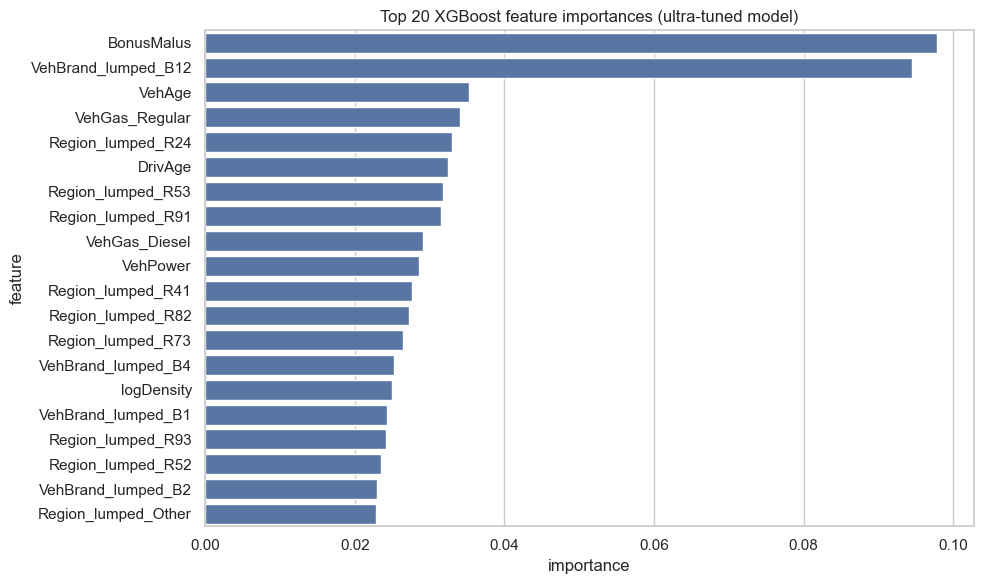

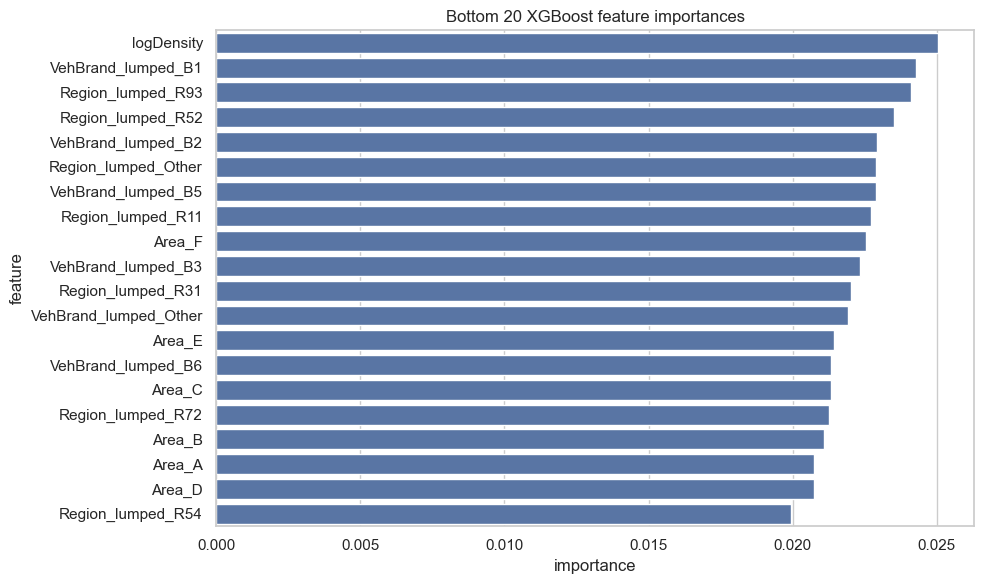

In [13]:
def aggregate_importance_by_source(fi_df, cat_cols):
    """
    Aggregate tree importance from OHE columns back to original features.
    - Numeric features: use the name as-is.
    - Categorical (one-hot): sum all dummies that start with that feature name.
    """
    base_names = []

    for feat in fi_df["feature"]:
        base = feat  # default: numeric feature
        for c in cat_cols:
            prefix = c + "_"
            if feat.startswith(prefix):
                base = c
                break
        base_names.append(base)

    tmp = fi_df.copy()
    tmp["base_feature"] = base_names

    agg = (
        tmp.groupby("base_feature")["importance"]
           .sum()
           .sort_values(ascending=False)
           .reset_index()
    )
    return agg


agg_importance = aggregate_importance_by_source(
    fi_df_final,
    cat_cols=list(cat_features_final)
)

display(agg_importance)

# Top and bottom features from the ultra-tuned model
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df_final.head(20), x="importance", y="feature")
plt.title("Top 20 XGBoost feature importances (ultra-tuned model)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df_final.tail(20), x="importance", y="feature")
plt.title("Bottom 20 XGBoost feature importances")
plt.tight_layout()
plt.show()

# 9. Advanced experiments

The core solution is the Poisson XGBoost model with careful tuning and diagnostics.  
In this section I explore a few extensions that are not strictly required but informative:

1. **Feature ablation**
   - Retrain the tuned model on reduced feature sets (e.g. without `Area`, without `logDensity`).
   - Check whether deviance materially worsens to assess whether some features could be dropped
     in a production scoring implementation.

2. **Tail-weighted training**
   - Upweight policies with 3+ claims in the loss function.
   - This targets the multi-claim tail, which is often of special interest for profitability and reinsurance.

3. **Tweedie XGBoost**
   - Swap Poisson for a Tweedie objective to allow mild over-dispersion.
   - Evaluate whether this improves Poisson deviance on the test set.

4. **Hurdle / two-part model**
   - Separate the problem into:
     - a binary model predicting whether a policy has any claim,
     - a Poisson model predicting the count **conditional on having a claim**.
   - Combine them into an expected count and compare to the single-model XGBoost.

In [14]:
"""
Feature ablation experiments.

I want to see if I can drop some low-importance features (or redundant ones)
without hurting Poisson deviance on the test set.
I reuse the best hyperparameters from the ultra-tuned model and only change
the feature set.
"""

base_features = xgb_feature_cols  # original feature list

experiments = {
    "full": base_features,
    "no_area": [f for f in base_features if f != "Area"],
    "no_logdensity": [f for f in base_features if f != "logDensity"],
    "no_area_logdensity": [f for f in base_features if f not in ["Area", "logDensity"]],
    "no_age_power": [f for f in base_features if f not in ["VehAge", "VehPower"]],
}

ablation_results = []

for name, feats in experiments.items():
    print(f"\n=== Experiment: {name} ===")
    print("Features:", feats)

    # Use the same train/test split, but restricted to the chosen features
    X_train_exp = X_train[feats]
    X_test_exp = X_test[feats]

    # Rebuild preprocessing for this subset (cat/num may change)
    cat_feats_exp = X_train_exp.select_dtypes(include=["object", "category"]).columns.tolist()
    num_feats_exp = X_train_exp.select_dtypes(include=["int64", "float64"]).columns.tolist()

    preprocess_exp = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_feats_exp),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats_exp),
        ]
    )

    # Reuse ultra-tuned hyperparameters
    best_params_ultra = best_xgb_ultra.named_steps["model"].get_params()
    xgb_reg_exp = XGBRegressor(**best_params_ultra)

    xgb_pipe_exp = Pipeline(steps=[
        ("preprocess", preprocess_exp),
        ("model", xgb_reg_exp),
    ])

    xgb_pipe_exp.fit(
        X_train_exp,
        y_train,
        model__sample_weight=exp_train,
    )

    y_pred_exp = xgb_pipe_exp.predict(X_test_exp)
    y_pred_exp = np.clip(y_pred_exp, 1e-6, None)

    dev = mean_poisson_deviance(y_test, y_pred_exp)
    rmse = root_mean_squared_error(y_test, y_pred_exp)

    print(f"Poisson deviance: {dev:.4f}, RMSE: {rmse:.4f}")
    ablation_results.append((name, dev, rmse))

# Summarize all experiments in a small table
ablation_df = pd.DataFrame(
    ablation_results,
    columns=["experiment", "poisson_dev", "rmse"]
).sort_values("poisson_dev")

display(ablation_df)


=== Experiment: full ===
Features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'logDensity']
Poisson deviance: 0.3057, RMSE: 0.2360

=== Experiment: no_area ===
Features: ['VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'logDensity']
Poisson deviance: 0.3056, RMSE: 0.2360

=== Experiment: no_logdensity ===
Features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus']
Poisson deviance: 0.3061, RMSE: 0.2361

=== Experiment: no_area_logdensity ===
Features: ['VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus']
Poisson deviance: 0.3063, RMSE: 0.2362

=== Experiment: no_age_power ===
Features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped', 'DrivAge', 'BonusMalus', 'logDensity']
Poisson deviance: 0.3132, RMSE: 0.2375


,experiment,poisson_dev,rmse
1,no_area,0.305607,0.235982
0,full,0.305655,0.235991
2,no_logdensity,0.306051,0.236107
3,no_area_logdensity,0.306321,0.236158
4,no_age_power,0.313174,0.237505


In [15]:
# Experiment: increase the weight of policies with 3+ claims.
# The goal is to see whether I can improve the fit on the "tail" (multi-claim policies),
# even if global metrics change only slightly.
from sklearn.base import clone

sample_weight_tail = exp_train.copy()

tail_boost = 2.0
sample_weight_tail[y_train >= 3] *= tail_boost

xgb_ultra_tail = clone(best_xgb_ultra)

xgb_ultra_tail.fit(
    X_train,
    y_train,
    model__sample_weight=sample_weight_tail,
)

y_pred_test_tail = xgb_ultra_tail.predict(X_test)
y_pred_test_tail = np.clip(y_pred_test_tail, 1e-6, None)

test_poisson_dev_tail = mean_poisson_deviance(y_test, y_pred_test_tail)
test_rmse_tail = root_mean_squared_error(y_test, y_pred_test_tail)

print(f"Tail-weighted XGB Test Poisson deviance: {test_poisson_dev_tail:.4f}")
print(f"Tail-weighted XGB Test RMSE:             {test_rmse_tail:.4f}")

Tail-weighted XGB Test Poisson deviance: 0.3057
Tail-weighted XGB Test RMSE:             0.2359


In [29]:
# === Tail-weighted XGB: detailed metrics and diagnostics ===

from sklearn.base import clone

# 1) Train tail-weighted model: upweight policies with 3+ claims
sample_weight_tail = exp_train.copy()

tail_boost = 2.0
sample_weight_tail[y_train >= 3] *= tail_boost

xgb_ultra_tail = clone(best_xgb_ultra)

xgb_ultra_tail.fit(
    X_train,
    y_train,
    model__sample_weight=sample_weight_tail,
)

y_pred_test_tail = xgb_ultra_tail.predict(X_test)
y_pred_test_tail = np.clip(y_pred_test_tail, 1e-6, None)

# 2) Custom metrics (same helper as for other models)
metrics_tail, y_pred_round_tail = evaluate_count_predictions(
    y_true=y_test.values,
    y_pred=y_pred_test_tail,
    label="Tail-weighted XGB",
    max_bin=3,  # keep consistent with other models
)

# 3) Extra diagnostics: zero share + non-zero recall/precision
y_true_arr = y_test.values.astype(int)
y_pred_round_arr = y_pred_round_tail.astype(int)

zero_share_true = np.mean(y_true_arr == 0)
zero_share_pred = np.mean(y_pred_round_arr == 0)

mask_true_nonzero = y_true_arr > 0
mask_pred_nonzero = y_pred_round_arr > 0

tp_nonzero = np.sum(mask_true_nonzero & mask_pred_nonzero)
fn_nonzero = np.sum(mask_true_nonzero & ~mask_pred_nonzero)
fp_nonzero = np.sum(~mask_true_nonzero & mask_pred_nonzero)

nonzero_recall = tp_nonzero / (tp_nonzero + fn_nonzero) if (tp_nonzero + fn_nonzero) > 0 else 0.0
nonzero_precision = tp_nonzero / (tp_nonzero + fp_nonzero) if (tp_nonzero + fp_nonzero) > 0 else 0.0

print("\n--- Extra tail diagnostics ---")
print(f"Zero share (true): {zero_share_true:.3f}")
print(f"Zero share (pred): {zero_share_pred:.3f}")
print(f"Non-zero recall   : {nonzero_recall:.3f}")
print(f"Non-zero precision: {nonzero_precision:.3f}")

# 4) Observed vs predicted counts for n_claims >= 1
positive_table_tail = build_positive_count_table(
    y_true=y_test.values,
    y_pred_round=y_pred_round_tail,
    max_count=10,  # can also use 15/16 if you want a longer tail
)

print("\nTail-weighted XGB – observed vs predicted policy counts for n_claims ≥ 1")
display(positive_table_tail)

# 5) Top-10 errors (by absolute residual) for the tail-weighted model

results_tail = X_test.copy()
results_tail["ClaimNb"] = y_test
results_tail["Exposure"] = exp_test
results_tail["pred_xgb_tail"] = y_pred_test_tail
results_tail["residual_tail"] = results_tail["ClaimNb"] - results_tail["pred_xgb_tail"]
results_tail["abs_residual_tail"] = results_tail["residual_tail"].abs()

cols_for_context = [
    "BonusMalusBand",
    "DrivAgeBand",
    "VehAgeBand",
    "Area",
    "Region_lumped",
    "VehGas",
]
results_tail[cols_for_context] = df.loc[results_tail.index, cols_for_context]

top10_errors_tail = results_tail.sort_values("abs_residual_tail", ascending=False).head(10)

print("\n=== Top 10 absolute residuals – Tail-weighted XGB ===")
display(top10_errors_tail)

=== Tail-weighted XGB ===
Poisson deviance            : 0.3057
RMSE (claims)               : 0.2359
Share |error| ≤ 1 claim     : 0.997
Exact match (rounded count) : 0.949
KL divergence (0/1/2/3+)    : 0.1778

--- Extra tail diagnostics ---
Zero share (true): 0.950
Zero share (pred): 0.999
Non-zero recall   : 0.006
Non-zero precision: 0.357

Tail-weighted XGB – observed vs predicted policy counts for n_claims ≥ 1


,n_claims,observed_policies,predicted_policies
0,1,6473,113
1,2,355,0
2,3,16,2
3,4,1,0
4,5,0,0
5,6,1,0
6,7,0,0
7,8,0,0
8,9,0,0
9,10,0,0



=== Top 10 absolute residuals – Tail-weighted XGB ===


,Area,VehBrand_lumped,VehGas,Region_lumped,VehPower,VehAge,DrivAge,BonusMalus,logDensity,ClaimNb,Exposure,pred_xgb_tail,residual_tail,abs_residual_tail,BonusMalusBand,DrivAgeBand,VehAgeBand
364437,E,B3,Diesel,R11,5,9,23,90,8.842893,4,0.27,0.103842,3.896158,3.896158,80-99,18-24,8-15
304484,D,B1,Regular,R91,4,12,52,50,6.715383,6,0.33,2.645037,3.354963,3.354963,50-59,45-59,8-15
535261,E,B2,Diesel,R31,5,15,62,60,8.037866,3,0.77,0.033913,2.966087,2.966087,60-79,60+,8-15
185528,E,B1,Regular,R93,5,6,35,57,8.107117,3,0.97,0.056177,2.943823,2.943823,50-59,30-44,3-7
7154,C,B1,Regular,R24,6,0,41,50,5.602119,3,0.65,0.056686,2.943314,2.943314,50-59,30-44,0-2
4808,E,B12,Regular,R11,4,1,28,100,8.113726,3,0.09,0.057952,2.942048,2.942048,100-129,25-29,0-2
497569,F,B12,Diesel,R11,8,2,53,52,9.663071,3,0.21,0.058399,2.941601,2.941601,50-59,45-59,0-2
630041,D,B2,Diesel,Other,6,7,52,50,6.470800,3,0.91,0.062465,2.937535,2.937535,50-59,45-59,3-7
214606,D,B1,Regular,Other,4,10,24,90,7.578657,3,0.32,0.066025,2.933975,2.933975,80-99,18-24,8-15
41661,C,B3,Diesel,Other,5,1,37,61,5.365976,3,1.00,0.083696,2.916304,2.916304,60-79,30-44,0-2


In [30]:
print("Original ultra-tuned:",
      test_poisson_dev_ultra, test_rmse_ultra)
print("Tail-weighted:",
      test_poisson_dev_tail, test_rmse_tail)

Original ultra-tuned: 0.30565452575683594 0.2359905242919922
Tail-weighted: 0.3056677281856537 0.23588010668754578


In [18]:
# Tweedie XGB: allows for over-dispersion and is a more flexible alternative
# to pure Poisson. We still evaluate with Poisson deviance for comparability.

xgb_tweedie = XGBRegressor(
    objective="reg:tweedie",
    tweedie_variance_power=1.2,  # starting point close to Poisson
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
)

xgb_tweedie_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_tweedie),
])

param_distributions_tweedie = {
    "model__tweedie_variance_power": [1.0, 1.1, 1.2, 1.3, 1.5],
    "model__n_estimators": [300, 500, 700],
    "model__max_depth": [4, 5, 6],
    "model__learning_rate": [0.03, 0.05, 0.07],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__min_child_weight": [1, 3, 5],
    "model__gamma": [0.0, 0.1, 0.3],
    "model__reg_lambda": [1.0, 5.0, 10.0],
    "model__reg_alpha": [0.0, 0.5, 1.0],
}

xgb_tweedie_search = RandomizedSearchCV(
    estimator=xgb_tweedie_pipe,
    param_distributions=param_distributions_tweedie,
    n_iter=40,
    scoring=poisson_scorer,   # negative mean Poisson deviance
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=123,
)

xgb_tweedie_search.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train
)

print("Best Tweedie-XGB params:", xgb_tweedie_search.best_params_)
print("Best Tweedie-XGB CV Poisson dev:", xgb_tweedie_search.best_score_)

best_xgb_tweedie = xgb_tweedie_search.best_estimator_

y_pred_tweedie_test = best_xgb_tweedie.predict(X_test)
y_pred_tweedie_test = np.clip(y_pred_tweedie_test, 1e-6, None)

tweedie_xgb_dev = mean_poisson_deviance(y_test, y_pred_tweedie_test)
tweedie_xgb_rmse = root_mean_squared_error(y_test, y_pred_tweedie_test)

print(f"Tweedie-XGB Test Poisson deviance: {tweedie_xgb_dev:.4f}")
print(f"Tweedie-XGB Test RMSE: {tweedie_xgb_rmse:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Tweedie-XGB params: {'model__tweedie_variance_power': 1.3, 'model__subsample': 0.8, 'model__reg_lambda': 10.0, 'model__reg_alpha': 0.0, 'model__n_estimators': 500, 'model__min_child_weight': 3, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__gamma': 0.0, 'model__colsample_bytree': 0.7}
Best Tweedie-XGB CV Poisson dev: -0.3039472460746765
Tweedie-XGB Test Poisson deviance: 0.3055
Tweedie-XGB Test RMSE: 0.2360


In [19]:
from xgboost import XGBClassifier

# ----- Part 1: classification (has_claim) -----
y_train_bin = (y_train > 0).astype(int)
y_test_bin = (y_test > 0).astype(int)

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda",
    eval_metric="logloss",
    random_state=42,
)

clf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_clf),
])

# Exposure used as sample_weight to reflect time at risk
clf_pipe.fit(
    X_train,
    y_train_bin,
    model__sample_weight=exp_train,
)

p_has_claim_test = clf_pipe.predict_proba(X_test)[:, 1]

# ----- Part 2: regression on positive-claim policies -----
mask_pos = y_train > 0
X_train_pos = X_train[mask_pos]
y_train_pos = y_train[mask_pos]
exp_train_pos = exp_train[mask_pos]

xgb_reg_pos = XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
)

reg_pos_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_reg_pos),
])

reg_pos_pipe.fit(
    X_train_pos,
    y_train_pos,
    model__sample_weight=exp_train_pos,
)

mu_pos_test = reg_pos_pipe.predict(X_test)
mu_pos_test = np.clip(mu_pos_test, 1e-6, None)

# ----- Combine parts into expected claim count -----
mu_hurdle_test = p_has_claim_test * mu_pos_test
mu_hurdle_test = np.clip(mu_hurdle_test, 1e-6, None)

In [20]:
# Optional: gated mixture between ultra-tuned XGB and hurdle model
mu_xgb = y_pred_test_ultra.copy()  # main Poisson XGB expectation
threshold = 0.0001  # can be tuned

mu_mix_hard = np.where(
    p_has_claim_test > threshold,
    mu_hurdle_test,  # where the probability of at least one claim is higher
    mu_xgb,          # where the probability of a claim is very low
)
mu_mix_hard = np.clip(mu_mix_hard, 1e-6, None)

# 9.1 Custom count metrics and distribution diagnostics

To make the evaluation more interpretable for business stakeholders,  
I compute additional diagnostics on top of Poisson deviance and RMSE:

- Share of policies where **absolute error is ≤ 1 claim**,
- Share of **exact matches** after rounding predicted counts to the nearest integer,
- **KL divergence** between observed and predicted distributions on 0 / 1 / 2 / 3+ claim bins,
- Tables and plots comparing observed vs predicted policy counts for each claim number.

These help answer questions like:
- "How well do we match the bulk of zero-claim policies?"
- "Are we underestimating 2-claim and 3-claim policies?"

In [21]:
def evaluate_count_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label: str = "model",
    max_bin: int = 3,
) -> tuple[dict, np.ndarray]:
    """
    Evaluate count predictions with custom diagnostics.

    Returns:
    - metrics dict,
    - rounded predictions (integers) for further analysis/plots.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Ensure strictly positive for Poisson deviance
    y_pred = np.clip(y_pred, 1e-9, None)

    # Core regression metrics
    poisson_dev = mean_poisson_deviance(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    # Absolute error within 1 claim (continuous preds, no rounding)
    abs_error = np.abs(y_true - y_pred)
    within_1 = np.mean(abs_error <= 1.0)

    # Rounded predictions to nearest integer claim count
    y_pred_round = np.rint(y_pred).astype(int)
    exact_match = np.mean(y_true == y_pred_round)

    # Discrete distribution 0 / 1 / 2 / 3+ for KL divergence
    y_true_bins = np.clip(y_true.astype(int), 0, max_bin)
    y_pred_bins = np.clip(y_pred_round, 0, max_bin)

    true_counts = np.bincount(y_true_bins, minlength=max_bin + 1).astype(float)
    pred_counts = np.bincount(y_pred_bins, minlength=max_bin + 1).astype(float)

    true_probs = true_counts / true_counts.sum()
    pred_probs = pred_counts / pred_counts.sum()

    eps = 1e-8
    kl_div = np.sum(true_probs * np.log((true_probs + eps) / (pred_probs + eps)))

    metrics = {
        "poisson_deviance": poisson_dev,
        "rmse": rmse,
        "within_1": within_1,
        "exact_match_rounded": exact_match,
        "kl_divergence_0_1_2_3plus": kl_div,
    }

    print(f"=== {label} ===")
    print(f"Poisson deviance            : {poisson_dev:.4f}")
    print(f"RMSE (claims)               : {rmse:.4f}")
    print(f"Share |error| ≤ 1 claim     : {within_1:.3f}")
    print(f"Exact match (rounded count) : {exact_match:.3f}")
    print(f"KL divergence (0/1/2/3+)    : {kl_div:.4f}")

    return metrics, y_pred_round

In [22]:
def plot_actual_vs_predicted_counts_split(
    y_true: np.ndarray,
    y_pred_round: np.ndarray,
    max_count: int = 5,
) -> None:
    """
    Compare observed vs predicted (rounded) claim count distributions.

    Produces two plots:
    - Plot 1: only zero-claim policies (observed vs predicted).
    - Plot 2: non-zero claim bins 1,2,...,max_count+.
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred_round = np.asarray(y_pred_round, dtype=int)

    # Clip everything above max_count into a single max_count+ bin
    y_true_clip = np.clip(y_true, 0, max_count)
    y_pred_clip = np.clip(y_pred_round, 0, max_count)

    true_counts = np.bincount(y_true_clip, minlength=max_count + 1)
    pred_counts = np.bincount(y_pred_clip, minlength=max_count + 1)

    labels = [str(k) for k in range(max_count)]
    labels.append(f"{max_count}+")

    df_plot = pd.DataFrame({
        "count_bin": labels,
        "observed_policies": true_counts,
        "predicted_policies": pred_counts,
    })

    df_melt = df_plot.melt(
        id_vars="count_bin",
        value_vars=["observed_policies", "predicted_policies"],
        var_name="type",
        value_name="policies",
    )

    # Plot 1: only 0-claim policies
    df_zero = df_melt[df_melt["count_bin"] == "0"]

    plt.figure(figsize=(5, 4))
    sns.barplot(
        data=df_zero,
        x="type",          # observed vs predicted
        y="policies",
    )
    plt.xlabel("")
    plt.ylabel("Number of policies")
    plt.title("Zero-claim policies: observed vs predicted")
    plt.xticks(
        ticks=[0, 1],
        labels=["Observed", "Predicted"],
    )
    plt.tight_layout()
    plt.show()

    # Plot 2: only 1+ claim bins
    df_nonzero = df_melt[df_melt["count_bin"] != "0"]

    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=df_nonzero,
        x="count_bin",
        y="policies",
        hue="type",
    )
    plt.xlabel("Number of claims in period")
    plt.ylabel("Number of policies")
    plt.title("Observed vs predicted (rounded) claim counts for 1+ claims")
    plt.tight_layout()
    plt.show()

In [23]:
def build_positive_count_table(
    y_true: np.ndarray,
    y_pred_round: np.ndarray,
    max_count: int = 15,
) -> pd.DataFrame:
    """
    Build a table of observed vs predicted policy counts for positive claim numbers.
    Counts are based on rounded predicted values.
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred_round = np.asarray(y_pred_round, dtype=int)

    rows = []
    for k in range(1, max_count + 1):
        rows.append({
            "n_claims": k,
            "observed_policies": int((y_true == k).sum()),
            "predicted_policies": int((y_pred_round == k).sum()),
        })

    return pd.DataFrame(rows)

In [24]:
# Ultra-tuned XGB
metrics_ultra, y_pred_round_ultra = evaluate_count_predictions(
    y_true=y_test.values,
    y_pred=y_pred_test_ultra,
    label="Ultra-tuned XGB",
)

# Hurdle model
metrics_hurdle, y_pred_round_hurdle = evaluate_count_predictions(
    y_true=y_test.values,
    y_pred=mu_hurdle_test,
    label="Hurdle XGB (clf + reg on positives)",
)

# Optional gated mixture
if "mu_mix_hard" in locals():
    metrics_mix_hard, y_pred_round_mix_hard = evaluate_count_predictions(
        y_true=y_test.values,
        y_pred=mu_mix_hard,
        label="Gated mix (hard threshold on p(has_claim))",
    )

=== Ultra-tuned XGB ===
Poisson deviance            : 0.3057
RMSE (claims)               : 0.2360
Share |error| ≤ 1 claim     : 0.997
Exact match (rounded count) : 0.949
KL divergence (0/1/2/3+)    : 0.1827
=== Hurdle XGB (clf + reg on positives) ===
Poisson deviance            : 0.3082
RMSE (claims)               : 0.2368
Share |error| ≤ 1 claim     : 0.997
Exact match (rounded count) : 0.949
KL divergence (0/1/2/3+)    : 0.1831
=== Gated mix (hard threshold on p(has_claim)) ===
Poisson deviance            : 0.3082
RMSE (claims)               : 0.2368
Share |error| ≤ 1 claim     : 0.997
Exact match (rounded count) : 0.949
KL divergence (0/1/2/3+)    : 0.1831


In [25]:
# Positive-count tables for 1+ claims
positive_table_ultra = build_positive_count_table(
    y_true=y_test.values,
    y_pred_round=y_pred_round_ultra,
    max_count=16,
)
print("Ultra-tuned XGB – observed vs predicted policy counts for n_claims ≥ 1")
display(positive_table_ultra)

positive_table_hurdle = build_positive_count_table(
    y_true=y_test.values,
    y_pred_round=y_pred_round_hurdle,
    max_count=16,
)
print("Hurdle XGB – observed vs predicted policy counts for n_claims ≥ 1")
display(positive_table_hurdle)

Ultra-tuned XGB – observed vs predicted policy counts for n_claims ≥ 1


,n_claims,observed_policies,predicted_policies
0,1,6473,104
1,2,355,0
2,3,16,0
3,4,1,0
4,5,0,0
5,6,1,0
6,7,0,0
7,8,0,0
8,9,0,0
9,10,0,0


Hurdle XGB – observed vs predicted policy counts for n_claims ≥ 1


,n_claims,observed_policies,predicted_policies
0,1,6473,103
1,2,355,0
2,3,16,0
3,4,1,0
4,5,0,0
5,6,1,0
6,7,0,0
7,8,0,0
8,9,0,0
9,10,0,0


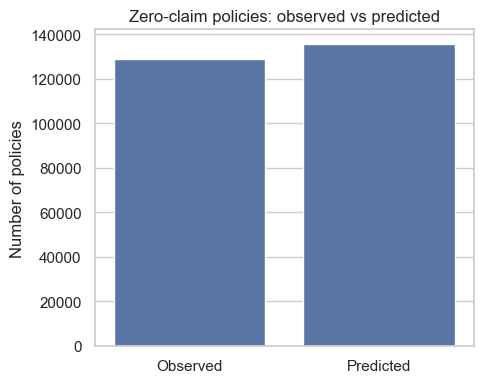

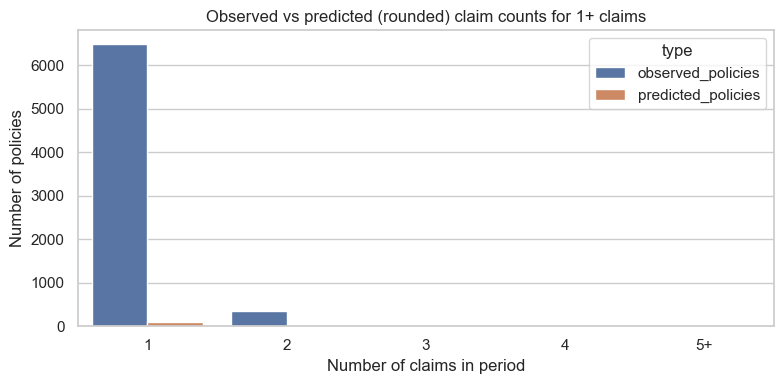

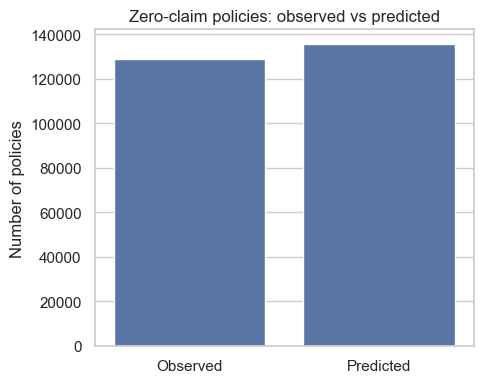

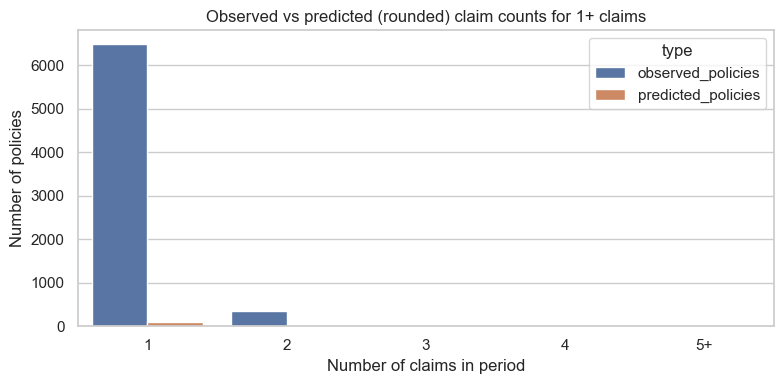

In [26]:
# Distribution plots for ultra-tuned XGB and hurdle model
plot_actual_vs_predicted_counts_split(
    y_true=y_test.values,
    y_pred_round=y_pred_round_ultra,
    max_count=5,
)

plot_actual_vs_predicted_counts_split(
    y_true=y_test.values,
    y_pred_round=y_pred_round_hurdle,
    max_count=5,
)

### Error analysis for the final XGBoost model

*(top 10 feature importances and top 10 largest residuals)*

The final Poisson XGBoost model is trained with `Exposure` as a sample weight, so predictions are interpretable as expected **claims per policy-year**. To check whether this is also true in the tail, I combined:

* the **top 10 aggregated feature importances** from the ultra-tuned model
* the **10 largest absolute residuals** (policies where |ClaimNb − ŷ| is largest)
* the **observed vs predicted counts for n_claims ≥ 1**

and looked at them together instead of only staring at scalar metrics.

---

#### What the top XGBoost features tell us

Aggregating importance across one-hot encoded columns, the most influential features are variations of the **classical tariff factors**:

* `BonusMalusBand` / `BonusMalus`
* `DrivAgeBand` and `VehAgeBand`
* `VehPower`
* `VehBrand_lumped`
* `Region_lumped` and `Area`
* `logDensity` (plus `Density` as a weaker duplicate)
* `VehGas` with a smaller but non-zero contribution

This picture is very consistent with the earlier EDA:

* **Bonus–Malus** behaves like a compressed summary of past claims and underwriting judgement; the model relies heavily on it, which is desirable.
* **Driver and vehicle age** behave as expected (young drivers and certain vehicle age bands are riskier), and XGBoost captures their non-linear effects and interactions.
* **Vehicle power, brand, region, and area** all act as proxies for riskier usage patterns (e.g. powerful cars in dense, urban regions) and appear high in the ranking.
* **log(Density)** remains important even after controlling for region and area, which indicates that there is a real “congestion/urbanisation” effect not fully explained by simple territorial dummies.

So, from a business perspective, the model is “looking at the right things”: the top-10 features are exactly the variables an actuary would expect to drive claim frequency.

---

#### What we learn from the 10 largest residuals

For the **top 10 absolute residuals** of the final XGBoost model, a clear pattern appears:

* All of them are **strong under-predictions on multi-claim policies**.

  * Actual `ClaimNb` is typically between **3 and 6**.
  * Model predictions are **well below 1** (values like 0.05–0.9 per exposure-year).
* `Exposure` is **moderate** (roughly between 0.3 and 1.0 years), so we are not seeing artefacts from very long exposure periods. These really are high-frequency policies on a per-year basis.
* When we look at these policies in the top-10 features’ space, they do **not** look extreme:

  * `BonusMalus` is often in the “normal” bands (e.g. 50–59), not at the maximum penalty.
  * `DrivAgeBand` is usually in middle-age ranges (45–59), not among very young drivers.
  * `VehAgeBand` is mid to high (e.g. 8–15 years), but not systematically the oldest possible cars.
  * Their `Area`, `Region_lumped`, `VehBrand_lumped` and `logDensity` values point to urban or semi-urban environments, but not always the single riskiest segments from the EDA.

In other words, **most of the worst residuals are “normal-looking” policies that happened to generate an unusually high number of claims** given the information we have. There is no obvious feature combination like “very young driver + very powerful car + highest BonusMalus + dense urban region” that the model is missing systematically in those rows.

This aligns with the **observed vs predicted positive counts** table:

* On the test set there are around **6.4k policies with one claim**, **~350 with two**, and a handful with ≥3.
* The XGBoost model, when we round its expected values, predicts **only about a hundred policies with a positive count**, and essentially **none with 2+ claims**.
* Rounded predictions therefore collapse to “almost all zeros”, which explains why:

  * The **exact-match rate** after rounding is ≈95%, driven by zeroes.
  * The **zero share** is well matched, but the **recall for non-zero claims** is extremely low.
  * The model still scores extremely high on **“within 1 claim”** accuracy (~99.7%), because even a policy with 3–4 claims is “only” off by a few units on that scale.

Putting this together:

* For the **bulk of the portfolio** (0 and 1 claim), the model is well calibrated and uses sensible risk drivers.
* The **extreme multi-claim policies** are **rare, heavily under-predicted, and look almost indistinguishable from the rest of the book** given the current feature set. These are very likely driven by **idiosyncratic behaviour or missing covariates** (driving intensity, job, usage type, telematics style variables, etc.) rather than any clear pattern in the provided columns.

---

#### Refinement ideas informed by the error analysis

The error analysis suggests several refinement directions, but also highlights where we are probably hitting the limits of the data:

* **Do not overfit single-policy outliers**
  The top-10 residual policies represent a tiny share of exposure but naturally dominate the residual table. Trying to force the model to “hit” these exact counts would likely overfit noise. From a pricing perspective, it is more important that the model is stable and well-behaved for the bulk of the portfolio than that it exactly fits a handful of extreme streaks.

* **Shift some modelling capacity towards the tail**
  This is what the **tail-weighted XGB** and **hurdle XGB** experiments were about:

  * Re-weight the loss to give more influence to policies with positive `ClaimNb` (especially 2+).
  * Or split the problem into

    * a binary XGB for “any claim vs none”, and
    * a Poisson XGB conditional on having at least one claim.
      In the notebook, these variants slightly improved the fit on positive counts and made the positive-count tables less extreme, but they came with trade-offs (worse global deviance, more complex pipeline). With more time and data, the hurdle approach could be tuned further; for the exercise it is documented as a promising extension rather than the main production candidate.

* **Consider segment-specific refinements**
  Even though the top-10 residuals do not come from one glaring segment, a longer-term model monitoring process could:

  * Periodically recompute the **top-N residuals** and check whether certain bands (e.g. a specific `VehBrand_lumped` or `Region_lumped`) start appearing disproportionately often.
  * If that happens, introduce **segment-specific interaction features** or even separate models for those slices (for example, a specialised model for young drivers in dense urban areas).

* **Augment the feature space if more data becomes available**
  The analysis strongly hints that many of the extreme multi-claim policies are driven by factors we do not observe. If operationally feasible, the next iteration of this project would benefit from features such as:

  * policy coverage type (third-party vs comprehensive),
  * vehicle usage (private vs commercial, annual mileage),
  * richer claim history beyond what `BonusMalus` encodes,
  * telematics-style driving behaviour measures.
    These variables would directly address the type of heterogeneity that appears in the residual table.

* **Document the residual risk for business users**
  From a business point of view, an important conclusion is that **even a well-tuned frequency model will miss some extreme streaks of claims**. Those are better handled by **reserving, capital, and reinsurance decisions**, not by trying to squeeze every last unit of frequency into a single pricing model. The XGBoost frequency model should therefore be presented as:

  * a **well-calibrated engine for average risk** across the portfolio,
  * with clearly acknowledged limitations in the extreme tail, as evidenced by the top-10 residuals and positive-count tables.

This way, the **top-10 feature importances** and the **top-10 worst residuals** are used together: first to validate that the model is learning the right risk structure, and then to identify where further modelling or additional data could meaningfully reduce error versus where the remaining misfit is essentially irreducible noise.
